<a href="https://colab.research.google.com/github/Tower5954/TensorFlow/blob/main/05_Transfer_learning_in_TensorFlow_part_2_fine_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer learning with TensorFlow part 2: Fine-tuning

In the previous notebook, we covered transfer learning feature extraction, in this notebook we will go through a new kind of transfer learning: fine-tuning

In [41]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

import matplotlib.pyplot as plt
import matplotlib.image as mping
import os
import random


In [2]:
# Check if we are using a GPU
!nvidia-smi

Thu Dec 30 10:44:47 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   66C    P8    32W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Creating helper functions

It is a good idea, to put functions that you will use a lot in a script, that you can download and import into your notebooks (or elsewhere).

We have done this for some of the functions previously used here:
https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

In [3]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2021-12-30 10:44:47--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2021-12-30 10:44:47 (42.5 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [4]:
from helper_functions import create_tensorboard_callback,plot_loss_curves,unzip_data,walk_through_dir

## The data

This time we will see how we can use the pretrained models within tf.keras.applications and apply them to our own problem (recognising images of food)
link: https://www.tensorflow.org/api_docs/python/tf/keras/applications

In [5]:
# Get 10% of training data of 10 classes of food 101

In [6]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

--2021-12-30 10:44:48--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.195.128, 173.194.197.128, 64.233.191.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.195.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   101MB/s    in 1.6s    

2021-12-30 10:44:49 (101 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [7]:
unzip_data("10_food_classes_10_percent.zip")

In [8]:
# check how many images and subdirectories in the dataset

In [9]:
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/sushi'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/steak'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/hamburger'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images in '10_food_classes_10_percent

In [10]:
# Create training and test 

In [11]:
train_dir = "10_food_classes_10_percent/train" 
test_dir = "10_food_classes_10_percent/test"

In [12]:
import tensorflow as tf
IMG_SIZE = (254,254)
BATCH_SIZE = 32

train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                            image_size=IMG_SIZE,
                                                                            label_mode="categorical",
                                                                            batch_size=BATCH_SIZE)


test_data = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                image_size=IMG_SIZE,
                                                                label_mode="categorical",
                                                                batch_size=BATCH_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [13]:
train_data_10_percent

<BatchDataset shapes: ((None, 254, 254, 3), (None, 10)), types: (tf.float32, tf.float32)>

In [14]:
# Check the class names of the dataset

In [15]:
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [16]:
# See an example of a batch of data

for images, labels in train_data_10_percent.take(1):
  print(images,labels)

tf.Tensor(
[[[[227.05702    220.05702    212.05702   ]
   [233.28993    229.28993    218.28993   ]
   [230.7041     228.7041     215.7041    ]
   ...
   [234.52362    236.25818    225.13322   ]
   [236.01575    237.01575    222.06299   ]
   [238.76581    237.50787    220.28168   ]]

  [[231.37617    227.37617    216.37617   ]
   [241.47638    237.47638    226.47638   ]
   [240.13097    238.13097    225.13097   ]
   ...
   [237.7588     239.7588     228.7588    ]
   [238.22693    238.45387    226.54836   ]
   [237.21869    238.21045    224.53113   ]]

  [[231.34418    229.34418    216.34418   ]
   [242.1407     238.1407     226.1407    ]
   [238.5516     234.5516     223.5516    ]
   ...
   [238.53937    238.53937    228.53937   ]
   [237.31993    238.78056    229.39868   ]
   [236.04724    238.81331    229.97078   ]]

  ...

  [[237.17944    235.17944    220.17944   ]
   [240.7588     238.7588     225.7588    ]
   [240.32718    238.90903    227.49086   ]
   ...
   [237.70908    237.709

## Model 0: Building a transfer learning feature extraction model using the keras functional API.

---



The sequential API is straightforward, it runs the layers in sequential order.

However, the functional API  gives more flexiability with models.
link: https://www.tensorflow.org/guide/keras/functional?hl=en

**1.** Create a base model with tf.keras.applications.

In [17]:
base_model = tf.keras.applications.EfficientNetB0(include_top=False)

16719872/16705208 [==============================] - 0s 0us/step




---



**2**. Freeze the base model (so the underlying pre-trained patterns aren't updated during training).

In [18]:
base_model.trainable = False



---






**3**. Create inputs in to the model.

In [19]:
inputs = tf.keras.layers.Input(shape=(254,254,3), name='input_layer')





---






**4**. If using ResNet50V2 you will need to normalise inputs (you don't have to for EffecientNet(s)).


In [20]:
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)



---



**5**. Pass the inputs to the base_model.

In [21]:
x = base_model(inputs)
print(f"Shape after passing inputs through base model: {x.shape} ")

Shape after passing inputs through base model: (None, 7, 7, 1280) 




---





**6**. Average pool the outputs of the base model (aggregate all the most importantinformation, reduce number of computations). 

In [22]:
x = tf.keras.layers.GlobalAveragePooling2D(name='global_avg_pooling_layer')(x)
print(f"Shape after GlobalAveragePooling2d: {x.shape}")

Shape after GlobalAveragePooling2d: (None, 1280)




---

**7**. Create the output activation layer.

In [23]:
outputs = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)



---

**8**. Combine the inputs with the outputs into a model.

In [24]:
model_0 = tf.keras.Model(inputs,outputs)



---

**9**. Compile the model

In [25]:
model_0.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])



---



**10**. Fit the model and save the history

In [26]:
history_10_percent = model_0.fit(train_data_10_percent,
                                 epochs = 5,
                                 steps_per_epoch = len(train_data_10_percent),
                                 validation_data = test_data,
                                 validation_steps = int(0.25 * len(test_data)),
                                 callbacks = [create_tensorboard_callback(dir_name="transfer_learning",
                                                                          experiment_name="10_percent_feature_extraction")]
                                 )

Saving TensorBoard log files to: transfer_learning/10_percent_feature_extraction/20211230-104504


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


Epoch 1/5
24/24 [==============================] - 28s 486ms/step - loss: 1.9419 - accuracy: 0.3773 - val_loss: 1.3788 - val_accuracy: 0.6891
Epoch 2/5
24/24 [==============================] - 9s 379ms/step - loss: 1.1713 - accuracy: 0.7200 - val_loss: 0.9516 - val_accuracy: 0.7796
Epoch 3/5
24/24 [==============================] - 10s 383ms/step - loss: 0.8555 - accuracy: 0.8053 - val_loss: 0.7861 - val_accuracy: 0.8109
Epoch 4/5
24/24 [==============================] - 8s 309ms/step - loss: 0.6960 - accuracy: 0.8373 - val_loss: 0.6715 - val_accuracy: 0.8355
Epoch 5/5
24/24 [==============================] - 8s 331ms/step - loss: 0.5892 - accuracy: 0.8693 - val_loss: 0.6178 - val_accuracy: 0.8421


In [27]:
# Evaluate on the full test data

model_0.evaluate(test_data)

79/79 [==============================] - 13s 159ms/step - loss: 0.6075 - accuracy: 0.8444


[0.6074715256690979, 0.8443999886512756]

In [28]:
# Check the layers in the base model

for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name)

0 input_1
1 rescaling
2 normalization
3 stem_conv_pad
4 stem_conv
5 stem_bn
6 stem_activation
7 block1a_dwconv
8 block1a_bn
9 block1a_activation
10 block1a_se_squeeze
11 block1a_se_reshape
12 block1a_se_reduce
13 block1a_se_expand
14 block1a_se_excite
15 block1a_project_conv
16 block1a_project_bn
17 block2a_expand_conv
18 block2a_expand_bn
19 block2a_expand_activation
20 block2a_dwconv_pad
21 block2a_dwconv
22 block2a_bn
23 block2a_activation
24 block2a_se_squeeze
25 block2a_se_reshape
26 block2a_se_reduce
27 block2a_se_expand
28 block2a_se_excite
29 block2a_project_conv
30 block2a_project_bn
31 block2b_expand_conv
32 block2b_expand_bn
33 block2b_expand_activation
34 block2b_dwconv
35 block2b_bn
36 block2b_activation
37 block2b_se_squeeze
38 block2b_se_reshape
39 block2b_se_reduce
40 block2b_se_expand
41 block2b_se_excite
42 block2b_project_conv
43 block2b_project_bn
44 block2b_drop
45 block2b_add
46 block3a_expand_conv
47 block3a_expand_bn
48 block3a_expand_activation
49 block3a_dwcon

In [29]:
# Summary of the base model
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling (Rescaling)          (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 normalization (Normalization)  (None, None, None,   7           ['rescaling[0][0]']              
                                3)                                                   

In [30]:
# Summary of the whole model

model_0.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 254, 254, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_avg_pooling_layer (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


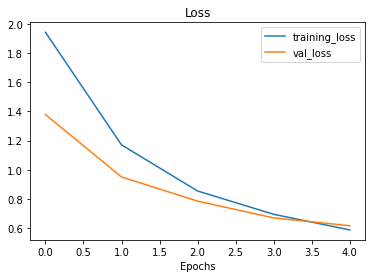

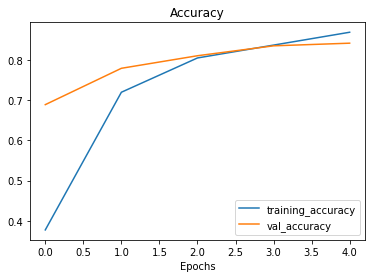

In [31]:
# Check the model'straining curves
plot_loss_curves(history_10_percent)

## Getting a feature vector from a trained model

Demonstrating the Global Average Pooling 2D layer...

We have a Tensor after the model goes through `base-model` of shape (None, 7, 7, 1280).

Then when it passes through GlobalAveragePooling2D it turns into (None,1280).

Let's use a similar shaped tensor of (1, 4, 4, 3) and then pass it to GlobalAveragePooling2D.

In [32]:
# Define the input shape
input_shape = (1, 4, 4, 3)

# Create a random tensor
tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape)

print(f"Random input tensor:\n {input_tensor} \n")

Random input tensor:
 [[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.2645474 ]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.8917141  -0.93847126]]

  [[ 0.77852213 -0.47338897  0.97772694]
   [ 0.24694404  0.20573747 -0.5256233 ]
   [ 0.32410017  0.02545409 -0.10638497]
   [-0.6369475   1.1603122   0.2507359 ]]

  [[-0.41728503  0.4012578  -1.4145443 ]
   [-0.5931857  -1.6617213   0.33567193]
   [ 0.10815629  0.23479682 -0.56668764]
   [-0.35819843  0.88698614  0.52744764]]]] 



In [33]:
# Pass the random tensor through a global average pooling 2d layer
global_average_pooled_layer = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)

print(f"2D Global average pooled random tensor:\n {global_average_pooled_layer} \n")

2D Global average pooled random tensor:
 [[-0.09368646 -0.45840448 -0.2885598 ]] 



In [34]:
# Check the shape of the different tensors
print(f"Shape of input tensors: {input_tensor.shape}")
print(f"Shape of global tensor: {global_average_pooled_layer.shape}")

Shape of input tensors: (1, 4, 4, 3)
Shape of global tensor: (1, 3)


In [35]:
# Replicating the GlobalAveragePool2D layer
tf.reduce_mean(input_tensor, axis=[1,2])

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840448, -0.2885598 ]], dtype=float32)>

Doing this not only makes the output of the base model compatible with the input shape requirement of our output layer (tf.keras.layers.Dense()), it also condenses the information found by the base model into a lower dimension **feature vector**.

🔑 Note: One of the reasons feature extraction transfer learning is named how it is is because what often happens is a pretrained model outputs a **feature vector** (a long tensor of numbers, in our case, this is the output of the tf.keras.layers.GlobalAveragePooling2D() layer) which can then be used to extract patterns out of.

### What is a feature vector?

A feature vector is **a learned representation of the input data** (a compressed form of the input data based on how the model see's it) 

## Running a series of transfer learning experiments

We have saw the results transfer learning can get with only 10% of the training data. However, now we will experiment and see how well it does with only 1% with a series of experiments such as:

1. `model_1` - use feature extraction transfer learning with 1% of the training data with data augmentation.
2. `model_2` - use feature extraction transfer learning with 10% of the training data with data augmentation.
3. `model_3` - use fine-tuning transfer learning with 10% of the training data with data augmentation.
4. `model_4` - use fine-tuning transfer learning with 100% of the training data with data augmentation. 

**Note**: Throughout all experiments the same test dataset will be used to evaluate our model... this ensures consistency across evaluation metrics.

### Getting and preprocessing data for model_1




In [36]:
# Download and unzip data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
unzip_data("10_food_classes_1_percent.zip")



--2021-12-30 10:46:33--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.197.128, 173.194.198.128, 64.233.191.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.197.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip’

10_food_classes_1_p 100%[===================>] 127.42M   212MB/s    in 0.6s    

2021-12-30 10:46:34 (212 MB/s) - ‘10_food_classes_1_percent.zip’ saved [133612354/133612354]



In [37]:
# Create training and test dirs

train_dir_1_percent = "10_food_classes_1_percent/train"
test_dir = "10_food_classes_1_percent/test"

In [38]:
# How many images are we working with?
walk_through_dir("10_food_classes_1_percent/train")

There are 10 directories and 0 images in '10_food_classes_1_percent/train'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ice_cream'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_wings'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/fried_rice'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_curry'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ramen'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/sushi'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/steak'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/hamburger'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/grilled_salmon'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/pizza'.


In [42]:
# Setup data loaders 

IMG_SIZE = (224, 224)
train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_1_percent,
                                                                           label_mode='categorical',
                                                                           image_size=IMG_SIZE,
                                                                           batch_size=32)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode='categorical',
                                                                image_size=IMG_SIZE,
                                                                batch_size=BATCH_SIZE)




Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


## Adding data augmentation into the model

To add data augmentation into the models, we can use the layers inside:

* `tf.keras.layers.experimental.preprocessing()` 

This a relatively new feature added to TensorFlow 2.2+ but it's very powerful. Adding a data augmentation layer to the model has the following benefits:

* Preprocessing of the images (augmenting them) happens on the GPU rather than on the CPU (much faster).
  * Images are best preprocessed on the GPU where as text and structured data are more suited to be preprocessed on the CPU.
* Image data augmentation only happens during training so we can still export our whole model and use it elsewhere. And if someone else wanted to train the same model as us, including the same kind of data augmentation, they could.


The data augmentation transformations we're going to use are:

* RandomFlip - flips image on horizontal or vertical axis.
* RandomRotation - randomly rotates image by a specified amount.
* RandomZoom - randomly zooms into an image by specified amount.
* RandomHeight - randomly shifts image height by a specified amount.
* RandomWidth - randomly shifts image width by a specified amount.
* Rescaling - normalizes the image pixel values to be between 0 and 1, this is worth mentioning because it is required for some image models but since we're using the tf.keras.applications implementation of EfficientNetB0, it's not required.

For more information on the other preprocessing layers avaiable and the different methods of data augmentation, check out the [ Keras preprocessing layers guide](https://keras.io/guides/preprocessing_layers/) and the
[TensorFlow data augmentation guide](https://www.tensorflow.org/tutorials/images/data_augmentation).


In [40]:
# Create data augmentation stage with horizontal flipping, rotations, zoom, etc.

data_augmentation = keras.Sequential([
      preprocessing.RandomFlip("horizontal"),
      preprocessing.RandomRotation(0.2),
      preprocessing.RandomZoom(0.2),
      preprocessing.RandomHeight(0.2),
      preprocessing.RandomWidth(0.2),
      #preprocessing.Rescale(1./255) Keep for models like ResNet50v2 but EffecientNet's have rescaling built-in
], name="data_augmentation")

### Visualise the data augmentation layer (and see what happens to the data)

In [43]:
# View a random image and compare it to the augmented image.

target_class = random.choice(train_data_1_percent.class_names)

In [45]:
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [46]:
target_dir = "10_food_classes_1_percent/train/" + target_class

In [47]:
print(target_dir)

10_food_classes_1_percent/train/pizza


In [48]:
random_image = random.choice(os.listdir(target_dir))

In [49]:
print(random_image)

2705497.jpg


In [50]:
random_image_path = target_dir + '/' + random_image

In [51]:
print(random_image_path)

10_food_classes_1_percent/train/pizza/2705497.jpg


In [52]:
# Read in the random image

img = mping.imread(random_image_path)

In [53]:
print(img)

[[[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [ 50  41  42]
  [ 51  45  45]
  [ 39  33  33]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [ 52  43  44]
  [ 52  46  46]
  [ 40  34  34]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [ 51  42  43]
  [ 48  42  42]
  [ 36  30  30]]

 ...

 [[ 91  88  97]
  [ 84  81  90]
  [ 85  82  91]
  ...
  [ 12  10  13]
  [ 17  15  18]
  [ 22  20  23]]

 [[ 96  93 104]
  [ 84  81  92]
  [ 82  79  90]
  ...
  [ 43  41  44]
  [ 21  19  22]
  [  9   7  10]]

 [[103  97 109]
  [ 87  84  95]
  [ 81  78  89]
  ...
  [ 71  69  72]
  [ 39  37  40]
  [ 19  17  20]]]


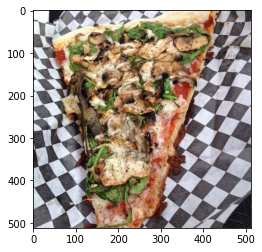

In [54]:
plt.imshow(img)

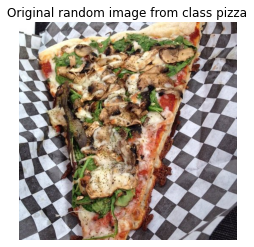

In [55]:
plt.imshow(img)
plt.title(f"Original random image from class: {target_class}")
plt.axis(False);

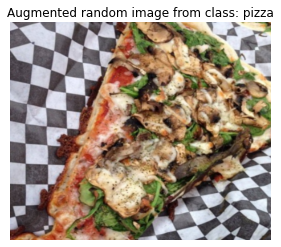

In [58]:
# Now plot the augmented random image

augmented_img = data_augmentation(tf.expand_dims(img, axis=0))
plt.figure()
plt.title(f"Augmented random image from class: {target_class}")
plt.axis(False)
plt.imshow(tf.squeeze(augmented_img / 255.));


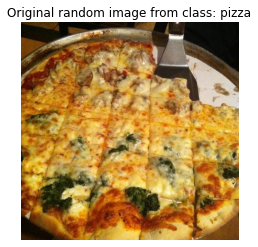

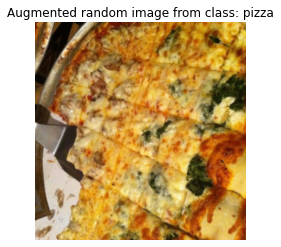

In [63]:
target_dir = "10_food_classes_1_percent/train/" + target_class
random_image = random.choice(os.listdir(target_dir))
random_image_path = target_dir + '/' + random_image

img = mping.imread(random_image_path)

plt.imshow(img)
plt.title(f"Original random image from class: {target_class}")
plt.axis(False)

augmented_img = data_augmentation(tf.expand_dims(img, axis=0))
plt.figure()
plt.title(f"Augmented random image from class: {target_class}")
plt.axis(False)
plt.imshow(tf.squeeze(augmented_img / 255.));




## Model 1: Feature extraction transfer learning on 1 percent of the data with data augmentation.

Setup input shape and base model, freezing the base model layers

In [ ]:
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False


# Create input layers

inputs = layers.Input(shape=input_shape, name="input_shape")

# Add in data augmentation Sequential model as a layer

x = data_augmentation(inputs)

# Give base_model the inputs (after augmentation) and 